Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 50)                10800     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 51        
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________
Train on 300 samples, validate on 100 samples
Epoch 1/100
 - 0s - loss: 0.1450 - val_loss: 0.1771
Epoch 2/100
 - 0s - loss: 0.1252 - val_loss: 0.1481
Epoch 3/100
 - 0s - loss: 0.1077 - val_loss: 0.1225
Epoch 4/100
 - 0s - loss: 0.0923 - val_loss: 0.1006
Epoch 5/100
 - 0s - loss: 0.0790 - val_loss: 0.0830
Epoch 6/100
 - 0s - loss: 0.0682 - val_loss: 0.0701
Epoch 7/100
 - 0s - loss: 0.0601 - val_loss: 0.0622
Epoch 8/100
 - 0s - loss: 0.0549 - val_loss: 0.0580
Epoch 9/100
 - 0s - loss: 0.0518 - val_loss: 0.05

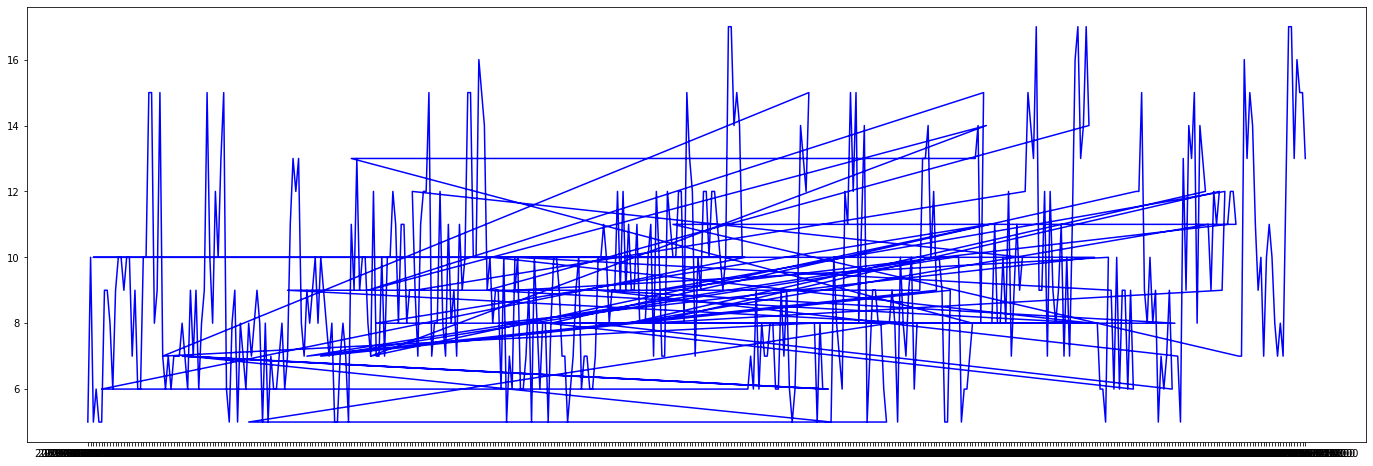

In [31]:
# 加载数据分析常用库
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import glob, os
import seaborn as sns
import sys
from sklearn.preprocessing import MinMaxScaler


#查看其中一个地区的训练数据
#feature=['YEAR','MONTH','DAY','TEMP_HIG','TEMP_COL','AVG_TEMP','AVG_WET','DATA_COL']
example = pd.read_csv('./data/dataCleaned.csv')
example.head()

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    #将数据存储成二维数据结构中
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        #将数据值都下移一个单位，用来做标题
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        #print(names)
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        #print(cols)
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        #print(names)
    # put it all together
    agg = pd.concat(cols, axis=1)
    #print(agg)
    agg.columns = names
    #print(agg)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
        
# 将数据归一化到0-1之间,无量纲化
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(example[['Doctor','Disease','WaitTime']].values)
#print(scaled_data[455:])
# 将时序数据转换为监督问题数据
reframed = series_to_supervised(scaled_data, 1, 1)
#print(reframed)
#删除无用的label数据，只预测TEMP_HIG
reframed.drop(reframed.columns[[3,4]], axis=1, inplace=True)
#print(reframed.values)

# 数据集划分,选取前400天的数据作为训练集,中间150天作为验证集,其余的作为测试集
train_days = 300
valid_days = 100
values = reframed.values
train = values[:train_days, :]
valid = values[train_days:train_days+valid_days, :]
test = values[train_days+valid_days:, :]
#获取训练数据集
train_X, train_y = train[:, :-1], train[:, -1]
#获取验证数据集
valid_X, valid_y = valid[:, :-1], valid[:, -1]
#获取测试数据集
test_X, test_y = test[:, :-1], test[:, -1]
# 将数据集重构为符合LSTM要求的数据格式,即 [样本，时间步，特征]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#print(test_y.shape)

#模型构建
model = Sequential()
model.add(LSTM(50, activation='relu',input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')  #loss='mae'
model.summary() 

history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(valid_X, valid_y), verbose=2, shuffle=False)


plt.figure(figsize=(24,8))
train_predict = model.predict(train_X)
valid_predict = model.predict(valid_X)
test_predict = model.predict(test_X)
#真实数据
plt.plot(example['Time'],example['WaitTime'], c='b')
#plt.plot([x for x in train_predict], c='g')
#plt.plot([None for _ in train_predict] + [x for x in valid_predict], c='y')
#plt.plot([None for _ in train_predict] + [None for _ in valid_predict] + [x for x in test_predict], c='r')
plt.show()

